In [25]:
#inport panda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
#read the csv file
df = pd.read_csv('datos-17001.csv',delimiter=';')
print(df.head())
df = df.drop(['date'],axis=1)

#normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_standardize = ['Sensor_O3', 'Temp', 'RelHum']

# Standardize the columns
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

print(df.head())

              date  RefSt  Sensor_O3   Temp  RelHum
0  21/06/2017 7:00   15.0    36.3637  21.77   53.97
1  21/06/2017 7:30   15.0    34.8593  25.50   42.43
2  21/06/2017 8:00   19.0    37.3510  27.97   34.93
3  21/06/2017 8:30   26.0    43.6993  29.41   32.07
4  21/06/2017 9:00   34.0    53.9600  30.20   30.83
   RefSt  Sensor_O3      Temp    RelHum
0   15.0  -1.154073 -0.496315  0.803695
1   15.0  -1.162821  0.082852  0.027663
2   19.0  -1.148333  0.466376 -0.476691
3   26.0  -1.111419  0.689968 -0.669017
4   34.0  -1.051757  0.812634 -0.752404


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
 

#split the data in 3 set train 80%, test 10% and validation 10%
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
test, val = train_test_split(test, test_size=0.5)

#split the data in input and output
x_train = train[['Sensor_O3', 'Temp', 'RelHum']].values
y_train = train['RefSt'].values
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


x_test = test[['Sensor_O3', 'Temp', 'RelHum']].values
y_test = test['RefSt'].values
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

x_val = val[['Sensor_O3', 'Temp', 'RelHum']].values
y_val = val['RefSt'].values
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)


# Define the neural network model
class FFNN(nn.Module):
    def __init__(self,hidden_size):
        super(FFNN, self).__init__()
        
        self.input_size = 3
        self.hidden_size = hidden_size
        self.output_size = 1

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Convert data to DataLoader for easy batching
dataset = TensorDataset(x_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [27]:
#define a list of hidden layers
hidden_layers = [2, 3, 4, 10]
losses = []
models = []
num_epochs = 500

# Training loop
for h in hidden_layers:
    loss_h = []
    model = FFNN(hidden_size=h)
    
    # Initialize the model, loss function, and optimizer
    criterion = nn.MSELoss()

    #use adam optimizer
    optimizer = optim.Adam(model.parameters())
    

    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, targets))
            loss.backward()
            optimizer.step()
        loss_h.append(loss.item())    
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    losses.append(loss_h)
    models.append(model)

plt.show()



Epoch [10/500], Loss: 78.6908
Epoch [20/500], Loss: 82.9230
Epoch [30/500], Loss: 55.9752
Epoch [40/500], Loss: 54.0235
Epoch [50/500], Loss: 53.2192
Epoch [60/500], Loss: 62.1714
Epoch [70/500], Loss: 48.2566
Epoch [80/500], Loss: 38.6427
Epoch [90/500], Loss: 33.8772
Epoch [100/500], Loss: 32.5917
Epoch [110/500], Loss: 27.3746
Epoch [120/500], Loss: 23.7550
Epoch [130/500], Loss: 19.9987
Epoch [140/500], Loss: 24.8107
Epoch [150/500], Loss: 24.6566
Epoch [160/500], Loss: 23.6578
Epoch [170/500], Loss: 29.5291
Epoch [180/500], Loss: 20.0399
Epoch [190/500], Loss: 23.1667
Epoch [200/500], Loss: 26.3401
Epoch [210/500], Loss: 19.9913
Epoch [220/500], Loss: 19.5577
Epoch [230/500], Loss: 12.2258
Epoch [240/500], Loss: 17.7100
Epoch [250/500], Loss: 19.1219
Epoch [260/500], Loss: 16.5806
Epoch [270/500], Loss: 16.9119
Epoch [280/500], Loss: 17.8924
Epoch [290/500], Loss: 17.5764
Epoch [300/500], Loss: 13.1288
Epoch [310/500], Loss: 16.1698
Epoch [320/500], Loss: 11.1709
Epoch [330/500], 

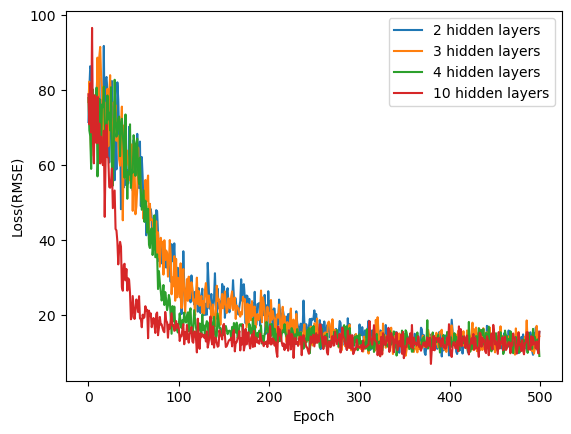

In [28]:
#plot the loss
for i in range(len(hidden_layers)):
    plt.plot(losses[i], label=f'{hidden_layers[i]} hidden layers')
    
    
plt.xlabel('Epoch')
plt.ylabel('Loss(RMSE)')
plt.legend()


In [29]:
from sklearn.metrics import mean_squared_error
RMSES = []

for i in range(len(models)):
    #calcilate RMSE for validation set
    criterion = nn.MSELoss()
    outputs = models[i](x_val_tensor)
    loss = torch.sqrt(criterion(outputs, y_val_tensor))
    print(f'RMSE of the model with {hidden_layers[i]} is: {loss.item():.4f}')
    RMSES.append(loss.item())

for i in range(len(models)):
    #calcilate RMSE for validation set using skleanr
    y_pred = models[i](x_val_tensor).detach().numpy().flatten()
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f'RMSE of the model with {hidden_layers[i]} is: {rmse}, for sklearn')




RMSE of the model with 2 is: 14.2456
RMSE of the model with 3 is: 14.5190
RMSE of the model with 4 is: 13.9696
RMSE of the model with 10 is: 13.2396
RMSE of the model with 2 is: 14.245594906416011, for sklearn
RMSE of the model with 3 is: 14.519023671984398, for sklearn
RMSE of the model with 4 is: 13.969642750037455, for sklearn
RMSE of the model with 10 is: 13.23960202673257, for sklearn


In [30]:
#take the model with the best RMSE
best_model = models[np.argmin(RMSES)]

#calculate RMSE for test set
criterion = nn.MSELoss()
outputs = best_model(x_test_tensor)
loss = torch.sqrt(criterion(outputs, y_test_tensor))
print(f'RMSE of the model with {hidden_layers[np.argmin(RMSES)]} is: {loss.item():.4f} for test set')

RMSE of the model with 10 is: 12.4268 for test set


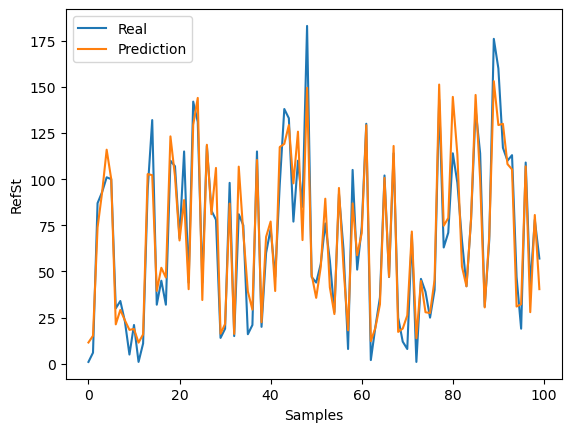

In [31]:
#plot the prediction and the real value for test set
plt.plot(y_test, label='Real')
plt.plot(outputs.detach().numpy(), label='Prediction')
plt.xlabel('Samples')
plt.ylabel('RefSt')
plt.legend()
plt.show()
